# Pairwise Quality Assessment - Attribute Analysis

Analyze how each method performs on different user-labeled quality attributes.

In [1]:
# Imports
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))
sys.path.insert(0, str(Path.cwd()))

from sim_bench.analysis.utils import get_project_root
from merge_pairwise_results import load_pairwise_results, merge_pairwise_results
from analyze_pairwise_by_attributes import (
    merge_results_with_labels,
    compute_accuracy_by_attribute,
    compute_accuracy_by_label_presence,
    plot_accuracy_by_majority_label,
    plot_method_performance_by_label,
)

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print("✓ Imports successful")

✓ Imports successful


## 1. Load Data

In [ ]:
# Configuration
PROJECT_ROOT = get_project_root()
# BENCHMARK_DIR = PROJECT_ROOT / "outputs" / "pairwise_benchmark_3hour" / "pairwise_20251120_100520"
BENCHMARK_DIR = PROJECT_ROOT / "outputs" / "pairwise_benchmark_test" / "pairwise_20251125_004908"
MERGED_RESULTS_PATH = BENCHMARK_DIR / "merged_pairwise_results.csv"
LABELS_PATH = Path(r"D:\Similar Images\automatic_triage_photo_series\photo_triage_pairs_keyword_labels.csv")

print(f"Benchmark dir: {BENCHMARK_DIR}")
print(f"Results file exists: {MERGED_RESULTS_PATH.exists()}")
print(f"Labels file exists: {LABELS_PATH.exists()}")

Benchmark dir: D:\sim-bench\outputs\pairwise_benchmark_3hour\pairwise_20251120_100520
Results file exists: True
Labels file exists: True


In [3]:
# Load pairwise results
pairwise_merged = pd.read_csv(MERGED_RESULTS_PATH)
print(f"Loaded pairwise results: {pairwise_merged.shape}")
print(f"Columns: {list(pairwise_merged.columns[:10])}...")
pairwise_merged.head()

Loaded pairwise results: (4000, 38)
Columns: ['pair_id', 'series_id', 'actual', 'CLIP-Aesthetic-LAION_correct', 'CLIP-Aesthetic-LAION_score_a', 'CLIP-Aesthetic-LAION_score_b', 'CLIP-Aesthetic-LAION_predicted', 'CLIP-Aesthetic-LAION_preference_strength', 'CLIP-LearnedPrompts_correct', 'CLIP-LearnedPrompts_score_a']...


,pair_id,series_id,actual,CLIP-Aesthetic-LAION_correct,CLIP-Aesthetic-LAION_score_a,CLIP-Aesthetic-LAION_score_b,CLIP-Aesthetic-LAION_predicted,CLIP-Aesthetic-LAION_preference_strength,CLIP-LearnedPrompts_correct,CLIP-LearnedPrompts_score_a,...,Exposure_correct,Exposure_score_a,Exposure_score_b,Exposure_predicted,Exposure_preference_strength,Sharpness_correct,Sharpness_score_a,Sharpness_score_b,Sharpness_predicted,Sharpness_preference_strength
0,4728_2_4,4728,B,0,0.008305,-0.000655,A,0.777,0,0.008305,...,0,0.946268,0.922568,A,0.777,1,0.282686,0.428920,B,0.777
1,532_1_2,532,B,1,-0.005250,0.005147,B,0.990,1,-0.005250,...,1,0.842914,0.912532,B,0.990,1,0.344564,0.728260,B,0.990
2,142_1_7,142,A,0,0.000656,0.006663,B,0.709,0,0.000656,...,1,0.950157,0.942675,A,0.709,1,1.000000,0.203757,A,0.709
3,1641_2_4,1641,A,1,0.015440,0.014912,A,0.912,1,0.015440,...,1,0.984904,0.982803,A,0.912,0,1.000000,1.000000,B,0.912
4,1440_1_2,1440,B,0,0.016580,0.016033,A,0.674,0,0.016580,...,0,0.962398,0.949405,A,0.674,1,0.246437,0.290780,B,0.674


In [13]:
df_labels = pd.read_csv(LABELS_PATH)
print(df_labels.columns)
df_labels.head()

Index(['series_id', 'compareID1', 'compareID2', 'compareFile1', 'compareFile2',
       'LEFT', 'RIGHT', 'Total', 'max_count', 'Agreement', 'MaxVote',
       'num_reviewers', 'majority_label', 'label_composition',
       'label_detail_visibility', 'label_distance_appropriateness',
       'label_dynamic_range', 'label_exposure_quality', 'label_field_of_view',
       'label_lighting_quality', 'label_motion_blur',
       'label_no_specific_attribute', 'label_sharpness',
       'label_subject_interest'],
      dtype='object')


,series_id,compareID1,compareID2,compareFile1,compareFile2,LEFT,RIGHT,Total,max_count,Agreement,...,label_detail_visibility,label_distance_appropriateness,label_dynamic_range,label_exposure_quality,label_field_of_view,label_lighting_quality,label_motion_blur,label_no_specific_attribute,label_sharpness,label_subject_interest
0,1,0,1,1-1.JPG,1-2.JPG,0,5,5,5,1.000000,...,1,0,0,0,1,0,0,0,1,1
1,1,0,2,1-1.JPG,1-3.JPG,0,4,4,4,1.000000,...,2,0,0,1,0,0,0,1,0,0
2,1,0,3,1-1.JPG,1-4.JPG,2,1,3,2,0.666667,...,1,0,0,0,1,0,0,1,0,0
3,1,1,0,1-2.JPG,1-1.JPG,1,0,1,1,1.000000,...,0,0,0,0,0,0,0,0,1,0
4,1,1,2,1-2.JPG,1-3.JPG,2,1,3,2,0.666667,...,0,0,0,0,0,0,0,3,0,0


In [14]:
df_labels[['compareFile1', 'compareFile2', 'majority_label']]

,compareFile1,compareFile2,majority_label
0,1-1.JPG,1-2.JPG,composition
1,1-1.JPG,1-3.JPG,detail_visibility
2,1-1.JPG,1-4.JPG,detail_visibility
3,1-2.JPG,1-1.JPG,sharpness
4,1-2.JPG,1-3.JPG,no_specific_attribute
...,...,...,...
24181,5951-2.JPG,5951-1.JPG,no_specific_attribute
24182,5952-1.JPG,5952-2.JPG,no_specific_attribute
24183,5952-2.JPG,5952-1.JPG,lighting_quality
24184,5953-1.JPG,5953-2.JPG,detail_visibility


In [23]:
df_reviews = pd.read_csv(r'D:\Similar Images\automatic_triage_photo_series\reviews_df.csv')
df_reviews.head()
df_reviews.dropna(subset=["reason_text"], axis=0).reset_index(drop=True).drop(columns=['userChoice','label']
).to_csv((r'D:\Similar Images\automatic_triage_photo_series\reviews_df_cleaned.csv'))

In [25]:
df_reviews['label'].unique()

array(['field_of_view', 'detail_visibility', 'subject_interest',
       'no_specific_attribute', 'sharpness', 'exposure_quality',
       'composition', 'distance_appropriateness', 'lighting_quality',
       'dynamic_range', 'motion_blur', 'no_reason_given'], dtype=object)

In [18]:
df_full_labels = pd.read_csv(r'D:\Similar Images\automatic_triage_photo_series\train_val\labels_db.csv')
print(df_full_labels.columns)

df_full_labels.head()

Index(['series_id', 'compareID1', 'compareID2', 'LEFT', 'RIGHT', 'Total',
       'max_count', 'Agreement', 'MaxVote', 'num_reviewers', 'majority_label',
       'label_composition', 'label_detail_visibility',
       'label_distance_appropriateness', 'label_dynamic_range',
       'label_exposure_quality', 'label_field_of_view',
       'label_lighting_quality', 'label_motion_blur', 'label_no_reason_given',
       'label_no_specific_attribute', 'label_sharpness',
       'label_subject_interest'],
      dtype='object')


,series_id,compareID1,compareID2,LEFT,RIGHT,Total,max_count,Agreement,MaxVote,num_reviewers,...,label_distance_appropriateness,label_dynamic_range,label_exposure_quality,label_field_of_view,label_lighting_quality,label_motion_blur,label_no_reason_given,label_no_specific_attribute,label_sharpness,label_subject_interest
0,1,0,1,0,5,5,5,1.000000,1,5,...,0,0,0,1,0,0,0,0,1,1
1,1,0,2,0,4,4,4,1.000000,2,4,...,0,0,1,0,0,0,0,1,0,0
2,1,0,3,2,1,3,2,0.666667,0,3,...,0,0,0,1,0,0,0,1,0,0
3,1,1,0,1,0,1,1,1.000000,1,1,...,0,0,0,0,0,0,0,0,1,0
4,1,1,2,2,1,3,2,0.666667,1,3,...,0,0,0,0,0,0,0,3,0,0


In [16]:
df_labels['majority_label'].value_counts()

majority_label
no_specific_attribute       12250
detail_visibility            4090
composition                  2460
exposure_quality             2103
sharpness                    1144
distance_appropriateness     1044
field_of_view                 596
lighting_quality              218
subject_interest              148
dynamic_range                  77
motion_blur                    56
Name: count, dtype: int64

In [4]:
# Merge with user attribute labels
combined_df = merge_results_with_labels(MERGED_RESULTS_PATH, LABELS_PATH)

# Get method names
pairwise_methods = [col.replace('_correct', '') for col in combined_df.columns if col.endswith('_correct')]

print(f"\nMerged data shape: {combined_df.shape}")
print(f"Pairs with labels: {len(combined_df)} ({len(combined_df)/len(pairwise_merged)*100:.1f}% coverage)")
print(f"\nMethods: {', '.join(pairwise_methods)}")

Loaded 4000 pairwise results
Loaded 24186 labeled pairs
Merged: 1363 pairs with both results and labels
Coverage: 34.1% of results have labels

Merged data shape: (1363, 62)
Pairs with labels: 1363 (34.1% coverage)

Methods: CLIP-Aesthetic-LAION, CLIP-LearnedPrompts, Colorfulness, Combined-RuleBased, Contrast, Exposure, Sharpness


## 2. Accuracy by Majority Label

Show how each method performs on different attribute categories (composition, sharpness, exposure, etc.)

In [5]:
# Compute accuracy by majority label
majority_label_accuracy = compute_accuracy_by_attribute(combined_df, pairwise_methods, 'majority_label')

print("Method Accuracy by User-Labeled Attribute:")
print("="*80)
display(majority_label_accuracy.sort_values('count', ascending=False))

Method Accuracy by User-Labeled Attribute:


,attribute,value,count,CLIP-Aesthetic-LAION_accuracy,CLIP-LearnedPrompts_accuracy,Colorfulness_accuracy,Combined-RuleBased_accuracy,Contrast_accuracy,Exposure_accuracy,Sharpness_accuracy
8,majority_label,no_specific_attribute,598,0.583612,0.583612,0.588629,0.575251,0.486622,0.596990,0.543478
1,majority_label,detail_visibility,262,0.534351,0.534351,0.606870,0.568702,0.500000,0.538168,0.541985
4,majority_label,exposure_quality,152,0.486842,0.486842,0.651316,0.585526,0.401316,0.546053,0.598684
0,majority_label,composition,147,0.510204,0.510204,0.530612,0.619048,0.476190,0.571429,0.489796
2,majority_label,distance_appropriateness,74,0.554054,0.554054,0.527027,0.567568,0.405405,0.743243,0.500000
9,majority_label,sharpness,54,0.648148,0.648148,0.555556,0.777778,0.481481,0.537037,0.722222
5,majority_label,field_of_view,39,0.410256,0.410256,0.641026,0.589744,0.410256,0.589744,0.538462
6,majority_label,lighting_quality,14,0.357143,0.357143,0.642857,0.500000,0.428571,0.500000,0.642857
10,majority_label,subject_interest,13,0.615385,0.615385,0.692308,0.692308,0.384615,0.538462,0.615385
3,majority_label,dynamic_range,5,1.000000,1.000000,0.600000,0.800000,0.200000,0.400000,0.800000


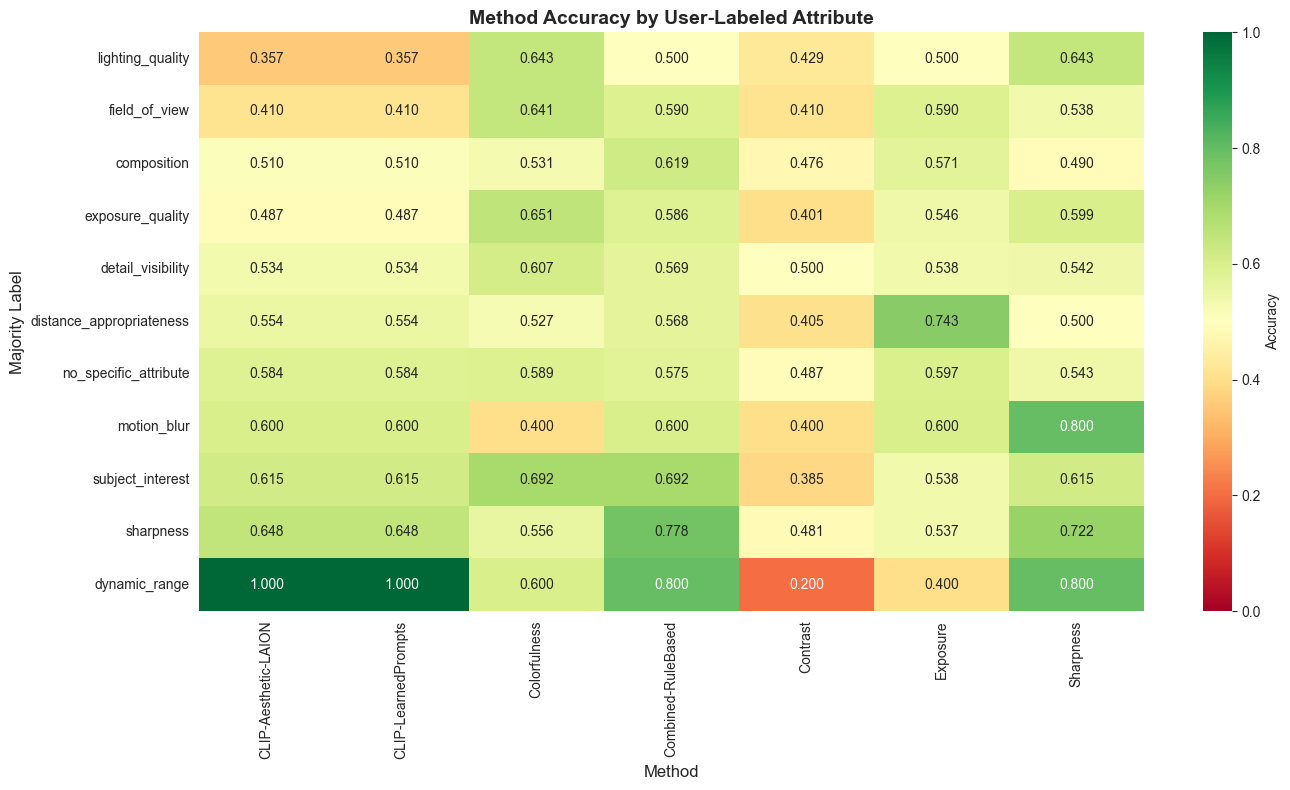

In [6]:
# Visualize as heatmap
fig = plot_accuracy_by_majority_label(majority_label_accuracy, pairwise_methods, figsize=(14, 8))
plt.show()

## 3. Attribute Presence Analysis

Compare performance when specific attributes are mentioned vs not mentioned

In [7]:
# Performance when specific attributes mentioned
label_cols = [col for col in combined_df.columns if col.startswith('label_') and 
              col not in ['label_no_reason_given', 'label_no_specific_attribute']]

label_presence = compute_accuracy_by_label_presence(combined_df, pairwise_methods, label_cols)

print("Accuracy when attribute PRESENT vs ABSENT:")
print("="*80)
display(label_presence.sort_values('present_count', ascending=False))

Accuracy when attribute PRESENT vs ABSENT:


,label,present_count,absent_count,CLIP-Aesthetic-LAION_present,CLIP-Aesthetic-LAION_absent,CLIP-Aesthetic-LAION_diff,CLIP-LearnedPrompts_present,CLIP-LearnedPrompts_absent,CLIP-LearnedPrompts_diff,Colorfulness_present,...,Combined-RuleBased_diff,Contrast_present,Contrast_absent,Contrast_diff,Exposure_present,Exposure_absent,Exposure_diff,Sharpness_present,Sharpness_absent,Sharpness_diff
1,detail_visibility,387,976,0.547804,0.552254,-0.004450,0.547804,0.552254,-0.004450,0.573643,...,0.010834,0.493540,0.459016,0.034524,0.583979,0.578893,0.005086,0.558140,0.549180,0.008959
4,exposure_quality,254,1109,0.539370,0.553652,-0.014282,0.539370,0.553652,-0.014282,0.665354,...,0.030765,0.393701,0.486023,-0.092323,0.566929,0.583408,-0.016479,0.594488,0.541930,0.052559
0,composition,234,1129,0.500000,0.561559,-0.061559,0.500000,0.561559,-0.061559,0.521368,...,0.021364,0.491453,0.464128,0.027325,0.589744,0.578388,0.011356,0.508547,0.560673,-0.052126
8,sharpness,228,1135,0.596491,0.541850,0.054641,0.596491,0.541850,0.054641,0.596491,...,0.087831,0.447368,0.473128,-0.025759,0.605263,0.575330,0.029933,0.600877,0.541850,0.059027
2,distance_appropriateness,147,1216,0.517007,0.555099,-0.038092,0.517007,0.555099,-0.038092,0.503401,...,-0.035105,0.442177,0.472039,-0.029863,0.639456,0.573191,0.066265,0.537415,0.553454,-0.016039
5,field_of_view,111,1252,0.495495,0.555911,-0.060415,0.495495,0.555911,-0.060415,0.630631,...,0.035360,0.387387,0.476038,-0.088651,0.621622,0.576677,0.044944,0.567568,0.550319,0.017248
9,subject_interest,78,1285,0.576923,0.549416,0.027507,0.576923,0.549416,0.027507,0.615385,...,0.000639,0.474359,0.468482,0.005876,0.641026,0.576654,0.064372,0.602564,0.548638,0.053926
6,lighting_quality,40,1323,0.550000,0.551020,-0.001020,0.550000,0.551020,-0.001020,0.625000,...,-0.014569,0.475000,0.468632,0.006368,0.550000,0.581255,-0.031255,0.675000,0.547997,0.127003
3,dynamic_range,17,1346,0.882353,0.546805,0.335548,0.882353,0.546805,0.335548,0.529412,...,0.118215,0.588235,0.467311,0.120925,0.352941,0.583210,-0.230268,0.705882,0.549777,0.156105
7,motion_blur,10,1353,0.400000,0.552106,-0.152106,0.400000,0.552106,-0.152106,0.500000,...,-0.089800,0.500000,0.468588,0.031412,0.600000,0.580192,0.019808,0.500000,0.552106,-0.052106


## 4. Composition Deep-Dive

In [8]:
# Composition analysis
composition_pairs = combined_df[combined_df['label_composition'] > 0]
print(f"COMPOSITION ANALYSIS ({len(composition_pairs)} pairs where 'composition' mentioned)")
print("="*80)

for method in pairwise_methods:
    correct_col = f'{method}_correct'
    comp_acc = composition_pairs[correct_col].mean()
    overall_acc = combined_df[correct_col].mean()
    diff = comp_acc - overall_acc
    
    sign = "✓" if diff > 0 else "✗" if diff < 0 else "="
    print(f"{sign} {method:25s}: {comp_acc:.3f} (overall: {overall_acc:.3f}, diff: {diff:+.3f})")

COMPOSITION ANALYSIS (234 pairs where 'composition' mentioned)
✗ CLIP-Aesthetic-LAION     : 0.500 (overall: 0.551, diff: -0.051)
✗ CLIP-LearnedPrompts      : 0.500 (overall: 0.551, diff: -0.051)
✗ Colorfulness             : 0.521 (overall: 0.591, diff: -0.069)
✓ Combined-RuleBased       : 0.607 (overall: 0.589, diff: +0.018)
✓ Contrast                 : 0.491 (overall: 0.469, diff: +0.023)
✓ Exposure                 : 0.590 (overall: 0.580, diff: +0.009)
✗ Sharpness                : 0.509 (overall: 0.552, diff: -0.043)


## 5. Per-Method Visualizations

Detailed analysis for top methods


Combined-RuleBased - Performance by Attribute


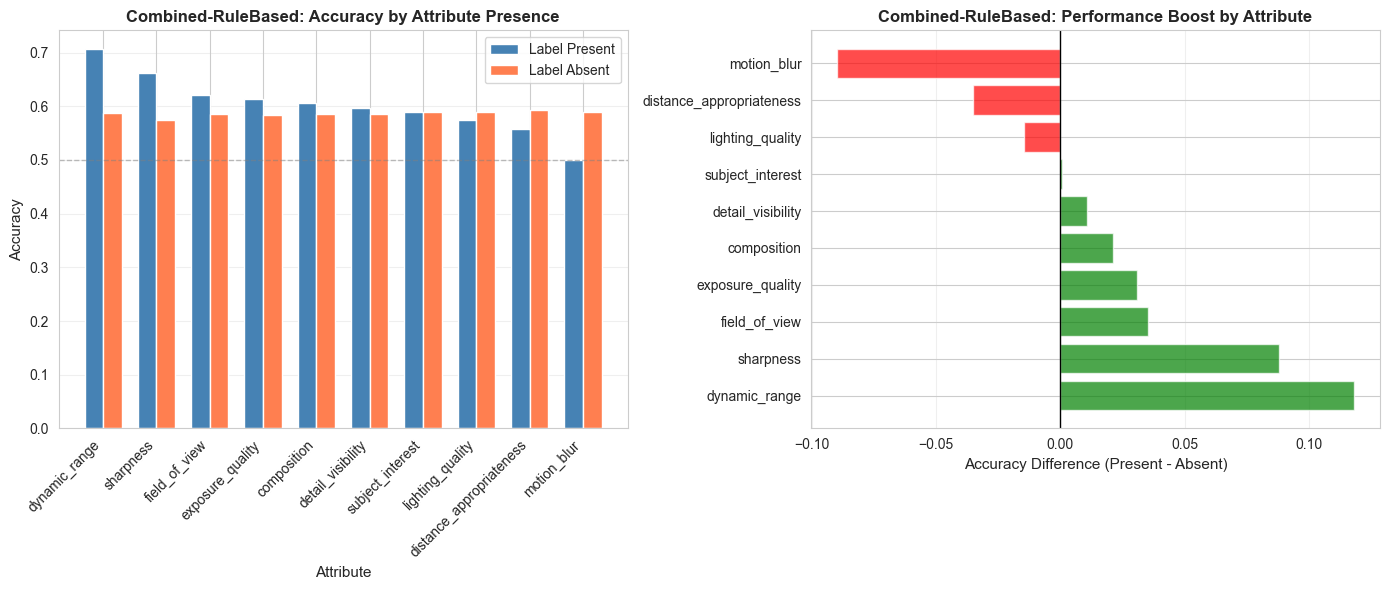


Sharpness - Performance by Attribute


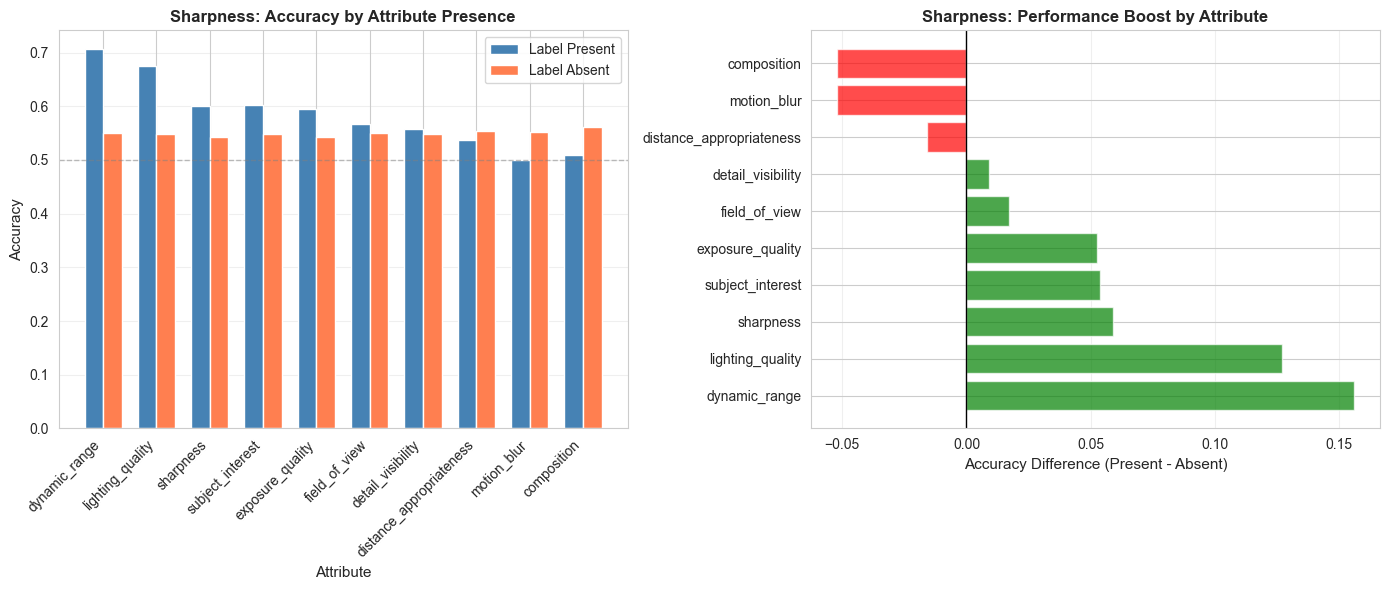


Colorfulness - Performance by Attribute


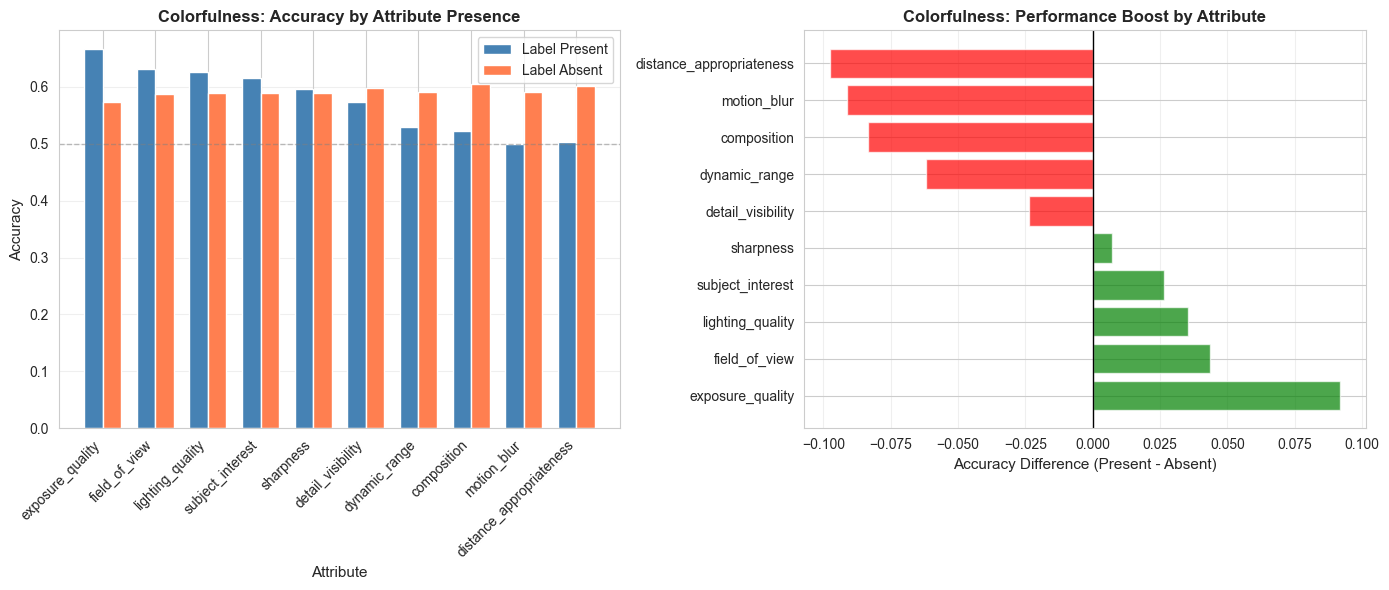

In [9]:
# Visualize top 3 methods
for method in ['Combined-RuleBased', 'Sharpness', 'Colorfulness']:
    print(f"\n{'='*80}")
    print(f"{method} - Performance by Attribute")
    print(f"{'='*80}")
    fig = plot_method_performance_by_label(label_presence, method, figsize=(14, 6))
    if fig:
        plt.show()
    else:
        print(f"Could not create visualization for {method}")